In [76]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
import random

from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

import matplotlib.pyplot as plt

In [77]:
train_df = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')

In [78]:
train_df, valid_df = train_test_split(train_df, test_size=0.2)

In [79]:
import sentencepiece as spm
SP_VOCAB_SIZE = 2048

In [80]:
with open('sb_train.txt', 'w' ) as f:
    for df in [train_df, valid_df, test_df]:
        for sent in df.question_text:
            print(sent, file=f)
        

In [81]:
sp_params = [
    '--pad_id=0',
    '--bos-id=1',
    '--eos-id=2',
    '--unk-id=3',
    '--input=sp_train.txt',
    '--model_prefix=sp',
    '--vocab_size={1024}',
    '--character_coverage=0.9995'
]

In [82]:
# spm.SentencePieceTrainer.Train(' '.join(sp_params))

In [83]:
with open('../input/subword-only-model/sp.vocab') as f:
    for line, i in zip(f, range(10)):
        print(line.rstrip())

<pad>	0
<s>	0
</s>	0
<unk>	0
?	-3.02119
s	-3.18372
▁the	-3.71501
▁a	-4.01083
▁What	-4.16155
▁to	-4.18061


In [84]:
spproc = spm.SentencePieceProcessor()

In [85]:
spproc.Load('../input/subword-only-model/sp.model')

True

In [86]:
train_df['subwords'] = train_df['question_text'].apply(lambda x: spproc.encode_as_ids(x))
valid_df['subwords'] = valid_df['question_text'].apply(lambda x: spproc.encode_as_ids(x))
test_df['subwords'] = test_df['question_text'].apply(lambda x: spproc.encode_as_ids(x))


In [87]:
train_df.head()

,qid,question_text,target,subwords
502010,6248da9d64da671aa40f,What was your experience as a mature student i...,0,"[8, 112, 57, 485, 98, 7, 320, 654, 518, 10, 7,..."
490420,600a6b84397e3b7cdfe9,Would you rather have twice the average physic...,0,"[451, 23, 1401, 46, 256, 96, 567, 6, 1003, 133..."
1147960,e0ec4fe9869287b55b0b,Is there any free accommodation in Bangalore?,0,"[42, 84, 115, 496, 7, 55, 534, 394, 25, 108, 1..."
731390,8f3cb37c35fa418bd344,What’s the greatest Football (Soccer) team to ...,0,"[8, 218, 5, 6, 713, 157, 193, 932, 15, 65, 436..."
1116912,dae09397575a88db679b,"No matter how good you are internally, people ...",0,"[996, 1418, 167, 118, 23, 21, 668, 28, 520, 18..."


In [88]:
train_df['l'] = train_df['subwords'].apply(lambda x : len(x))

In [89]:
train_df.head()

,qid,question_text,target,subwords,l
502010,6248da9d64da671aa40f,What was your experience as a mature student i...,0,"[8, 112, 57, 485, 98, 7, 320, 654, 518, 10, 7,...",20
490420,600a6b84397e3b7cdfe9,Would you rather have twice the average physic...,0,"[451, 23, 1401, 46, 256, 96, 567, 6, 1003, 133...",31
1147960,e0ec4fe9869287b55b0b,Is there any free accommodation in Bangalore?,0,"[42, 84, 115, 496, 7, 55, 534, 394, 25, 108, 1...",13
731390,8f3cb37c35fa418bd344,What’s the greatest Football (Soccer) team to ...,0,"[8, 218, 5, 6, 713, 157, 193, 932, 15, 65, 436...",24
1116912,dae09397575a88db679b,"No matter how good you are internally, people ...",0,"[996, 1418, 167, 118, 23, 21, 668, 28, 520, 18...",29


In [90]:
train_df.l.describe()

count    1.044897e+06
mean     2.147756e+01
std      1.204428e+01
min      1.000000e+00
25%      1.300000e+01
50%      1.800000e+01
75%      2.600000e+01
max      3.900000e+02
Name: l, dtype: float64

In [91]:
maxlen = int(train_df.quantile(0.99)['l'])

In [92]:
maxlen

66

In [93]:
# pad sequences
train_x = pad_sequences(train_df.subwords.values, maxlen=maxlen)
valid_x = pad_sequences(valid_df.subwords.values, maxlen=maxlen)
test_x = pad_sequences(test_df.subwords.values, maxlen=maxlen)


In [94]:
train_y = train_df['target'].values
valid_y = valid_df['target'].values

In [103]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

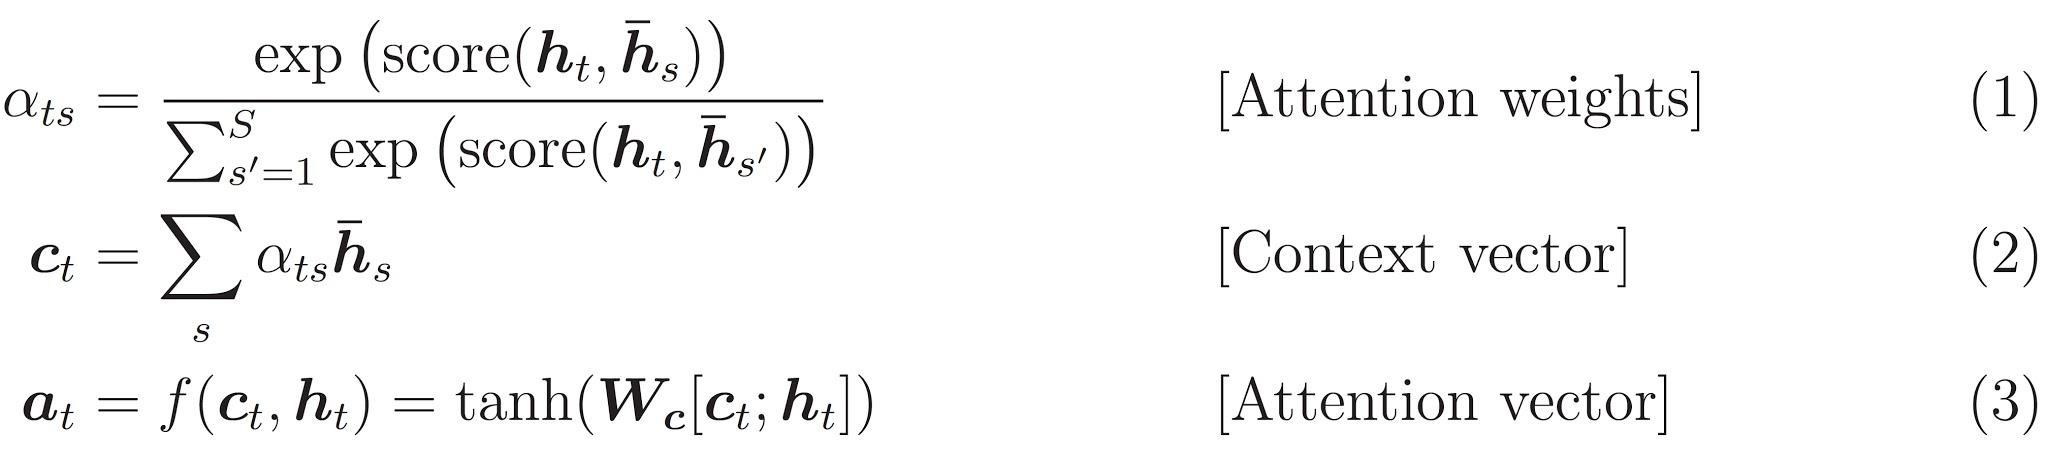


In [104]:
from keras.callbacks import Callback
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
    

def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [107]:
max_features = SP_VOCAB_SIZE

def build_model(embed_dim=15, trainable=True, lstm_dim=20, gru_dim=20, dense_dim=4, learning_rate=0.001):

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_dim, input_length=train_x.shape[1], trainable=trainable)(inp)
    x = SpatialDropout1D(0.1)(x)
    
    x = Bidirectional(LSTM(lstm_dim, return_sequences=True))(x)
    y = Bidirectional(GRU(gru_dim, return_sequences=True))(x)
    
    atten_1 = Attention(maxlen)(x)
    atten_2 = Attention(maxlen)(y)
    avg_pool = GlobalAveragePooling1D()(y)
    max_pool = GlobalMaxPooling1D()(y)
    
    conc = concatenate([atten_1, atten_2, avg_pool, max_pool])
    conc = Dense(dense_dim, activation="relu")(conc)
    conc = BatchNormalization()(conc)
    outp = Dense(1, activation="sigmoid")(conc) 
    
    model = Model(inputs=inp, outputs=outp)
    
    adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
    
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1])
    
    return model

In [108]:
model = build_model()

In [110]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 66)]         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 66, 15)       15360       input_14[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_12 (SpatialDr (None, 66, 15)       0           embedding_12[0][0]               
__________________________________________________________________________________________________
bidirectional_17 (Bidirectional (None, 66, 40)       5760        spatial_dropout1d_12[0][0]       
_______________________________________________________________________________________

In [111]:
from keras.utils import plot_model

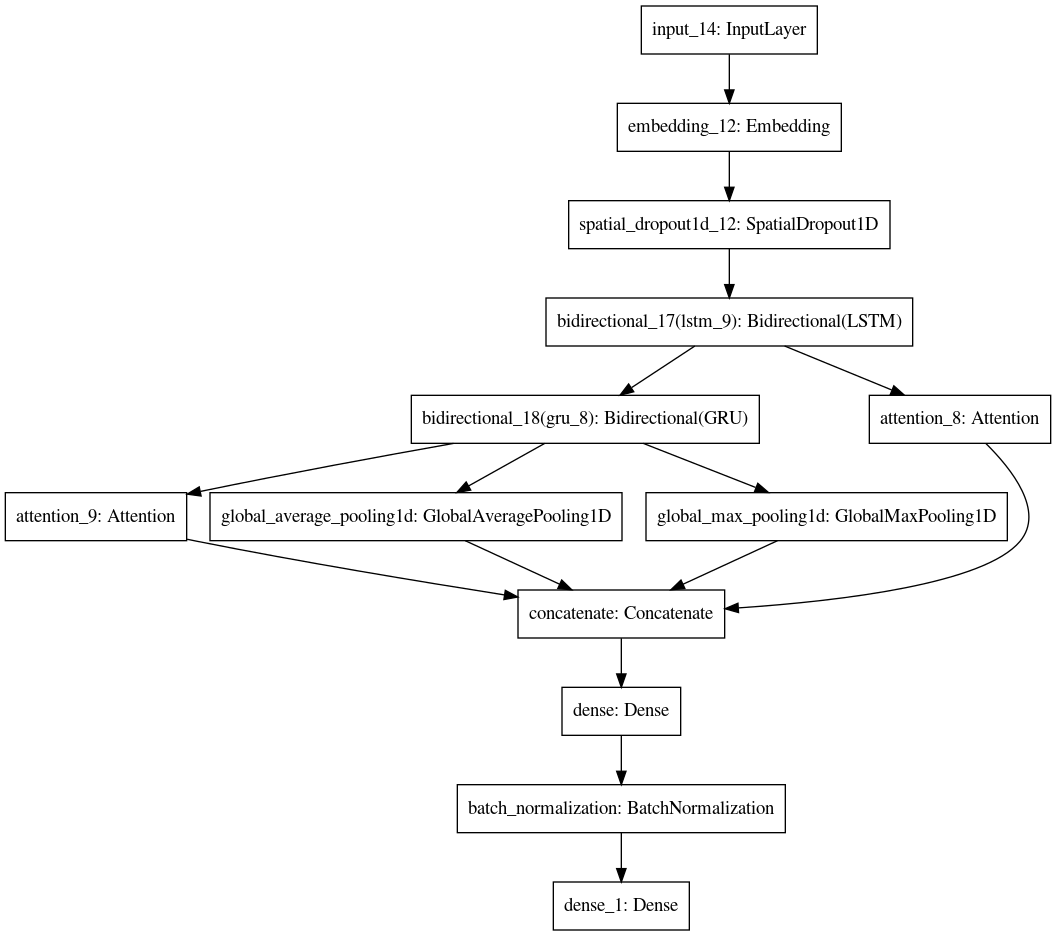

In [112]:
plot_model(model)

In [113]:

batch_size = 1024
step_size = float(4 * len(train_x)) / float(batch_size)

clr = CyclicLR(base_lr=0.001, max_lr=0.01, step_size=step_size, mode='exp_range', gamma=0.99994)


In [115]:
history = model.fit(train_x, train_y, batch_size=batch_size, epochs=10, validation_data=(valid_x, valid_y), callbacks=[clr])

Epoch 1/10


InvalidArgumentError:  indices[448,60] = 1239 is not in [0, 1024)
	 [[node functional_1/embedding_12/embedding_lookup (defined at <ipython-input-115-b4f73b310175>:1) ]] [Op:__inference_train_function_28026]

Errors may have originated from an input operation.
Input Source operations connected to node functional_1/embedding_12/embedding_lookup:
 functional_1/embedding_12/embedding_lookup/23385 (defined at /opt/conda/lib/python3.7/contextlib.py:112)

Function call stack:
train_function
